In [ ]:
!pip install yfinance pandas matplotlib seaborn scikit-learn tensorflow ta


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import ta


In [ ]:
!pip install --upgrade --no-cache-dir ta

In [ ]:
# Load NH stock data
stock_symbol = 'NH.NS'
df = yf.download(stock_symbol, start='2020-01-01', end='2025-06-15')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]



[*********************100%***********************]  1 of 1 completed


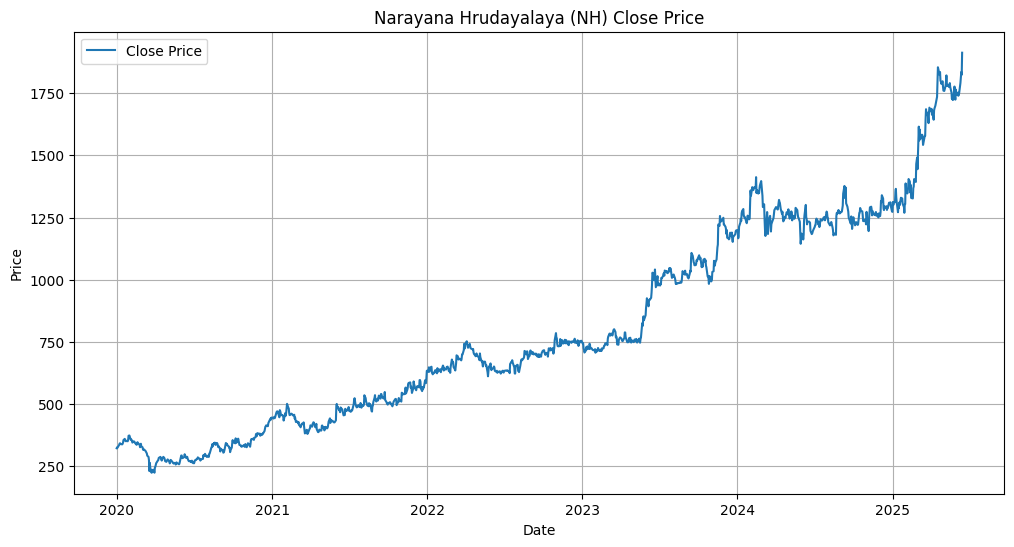

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title('Narayana Hrudayalaya (NH) Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Add technical indicators

# SMA - Simple Moving Averages
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA100'] = df['Close'].rolling(window=100).mean()

# RSI
df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'].astype(float), window=14).rsi()

# MACD
macd = ta.trend.MACD(close=df['Close'].astype(float))
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

# Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'].astype(float), window=20)
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()



In [ ]:
# Prepare data for LSTM
scaler = MinMaxScaler()

print("Data shape before scaling:", df[['Close']].shape)
print(df[['Close']].head())
scaled_data = scaler.fit_transform(df[['Close']])

sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Data shape before scaling: (1350, 1)
                 Close
Date                  
2020-01-01  321.863342
2020-01-02  325.565704
2020-01-03  324.183472
2020-01-06  333.365448
2020-01-07  335.340088


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0230 - val_loss: 0.0016
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0016 - val_loss: 8.6848e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0014 - val_loss: 9.1307e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0014 - val_loss: 9.2664e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0012 - val_loss: 9.5656e-04
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss

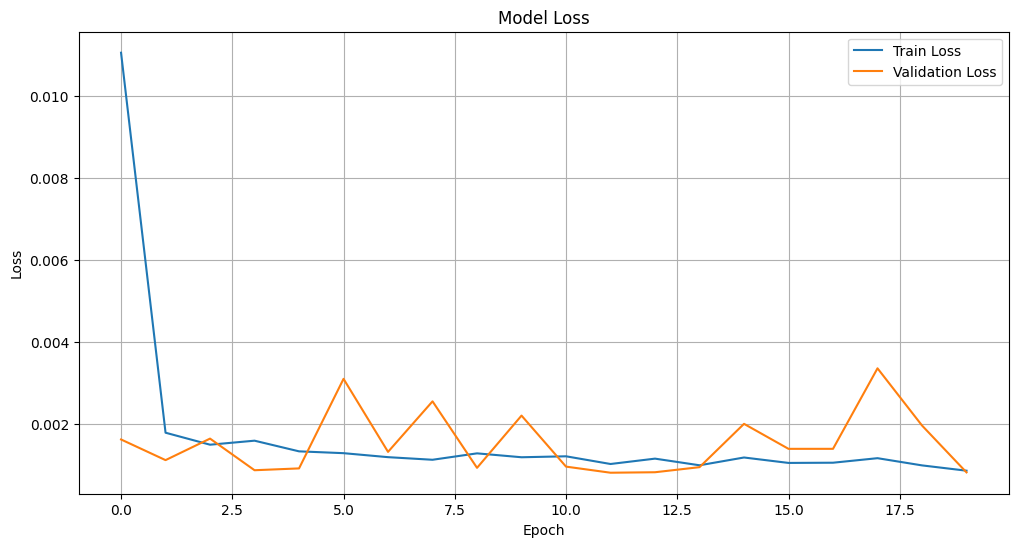

In [ ]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training history (optional)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)# Make Predictions
y_pred = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


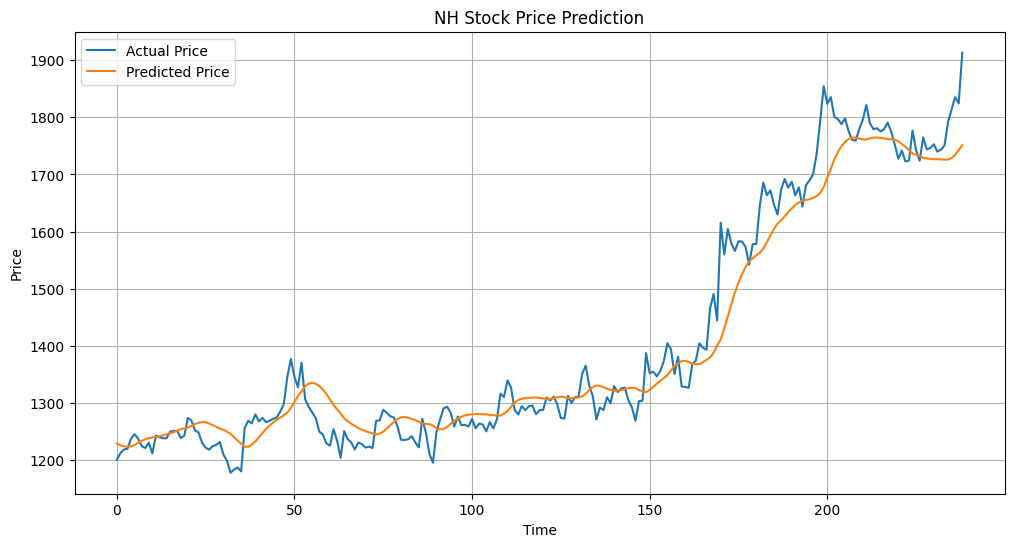

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')# Plot Actual vs Predicted
plt.title('NH Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()